In [174]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

plt.style.use('fivethirtyeight')

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 5

In [175]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

In [176]:
df = pd.read_csv('Super Store (1).csv', encoding='latin-1')

In [177]:
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,4,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
3,6,CA-2014-115812,6/9/2014,6/14/2014,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,California,90032,West,FUR-FU-10001487,Furniture,Furnishings,Eldon Expressions Wood and Plastic Desk Access...,48.8600,7,0.00,14.1694
4,11,CA-2014-115812,6/9/2014,6/14/2014,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,California,90032,West,FUR-TA-10001539,Furniture,Tables,Chromcraft Rectangular Conference Tables,1706.1840,9,0.20,85.3092


In [178]:
df['Region'].value_counts()

West       707
East       601
Central    481
South      332
Name: Region, dtype: int64

In [179]:
df_west = df[df['Region'] == 'West']

In [180]:
df_west.describe()

,Row ID,Postal Code,Sales,Quantity,Discount,Profit
count,707.000000,707.000000,707.000000,707.000000,707.000000,707.000000
mean,4999.953324,91680.442716,357.302325,3.813296,0.131400,16.272914
std,2814.077939,5024.265567,485.240433,2.249758,0.140481,99.926279
min,6.000000,59601.000000,3.480000,1.000000,0.000000,-814.483200
25%,2614.500000,90032.000000,51.859000,2.000000,0.000000,2.202600
50%,5145.000000,92105.000000,191.968000,3.000000,0.200000,11.995200
75%,7360.000000,94521.000000,465.809000,5.000000,0.200000,35.719800
max,9991.000000,99301.000000,3610.848000,14.000000,0.700000,629.010000


In [181]:
df_west.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
3,6,CA-2014-115812,6/9/2014,6/14/2014,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,California,90032,West,FUR-FU-10001487,Furniture,Furnishings,Eldon Expressions Wood and Plastic Desk Access...,48.860,7,0.0,14.1694
4,11,CA-2014-115812,6/9/2014,6/14/2014,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,California,90032,West,FUR-TA-10001539,Furniture,Tables,Chromcraft Rectangular Conference Tables,1706.184,9,0.2,85.3092
6,25,CA-2015-106320,9/25/2015,9/30/2015,Standard Class,EB-13870,Emily Burns,Consumer,United States,Orem,Utah,84057,West,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,1044.630,3,0.0,240.2649
15,66,CA-2015-135545,11/24/2015,11/30/2015,Standard Class,KM-16720,Kunst Miller,Consumer,United States,Los Angeles,California,90004,West,FUR-FU-10000397,Furniture,Furnishings,Luxo Economy Swing Arm Lamp,79.760,4,0.0,22.3328
24,105,US-2015-156867,11/13/2015,11/17/2015,Standard Class,LC-16870,Lena Cacioppo,Consumer,United States,Aurora,Colorado,80013,West,FUR-FU-10004006,Furniture,Furnishings,"Deflect-o DuraMat Lighweight, Studded, Beveled...",102.360,3,0.2,-3.8385


In [182]:
df_west.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 707 entries, 3 to 2120
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         707 non-null    int64  
 1   Order ID       707 non-null    object 
 2   Order Date     707 non-null    object 
 3   Ship Date      707 non-null    object 
 4   Ship Mode      707 non-null    object 
 5   Customer ID    707 non-null    object 
 6   Customer Name  707 non-null    object 
 7   Segment        707 non-null    object 
 8   Country        707 non-null    object 
 9   City           707 non-null    object 
 10  State          707 non-null    object 
 11  Postal Code    707 non-null    int64  
 12  Region         707 non-null    object 
 13  Product ID     707 non-null    object 
 14  Category       707 non-null    object 
 15  Sub-Category   707 non-null    object 
 16  Product Name   707 non-null    object 
 17  Sales          707 non-null    float64
 18  Quantity 

In [183]:
df_west = df_west[['Order Date', 'Sales']]

In [184]:
df_west['Order Date'] = pd.to_datetime(df_west['Order Date'])

In [185]:
df_west.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 707 entries, 3 to 2120
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Order Date  707 non-null    datetime64[ns]
 1   Sales       707 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 16.6 KB


In [186]:
df_west = df_west.groupby('Order Date')['Sales'].sum().reset_index()

In [187]:
df_west = df_west.set_index('Order Date')

In [188]:
df_west.head()

,Sales
Order Date,
2014-01-13,333.999
2014-01-19,181.470
2014-01-20,19.300
2014-01-27,333.000
2014-01-31,290.666


<Figure size 1200x1200 with 0 Axes>

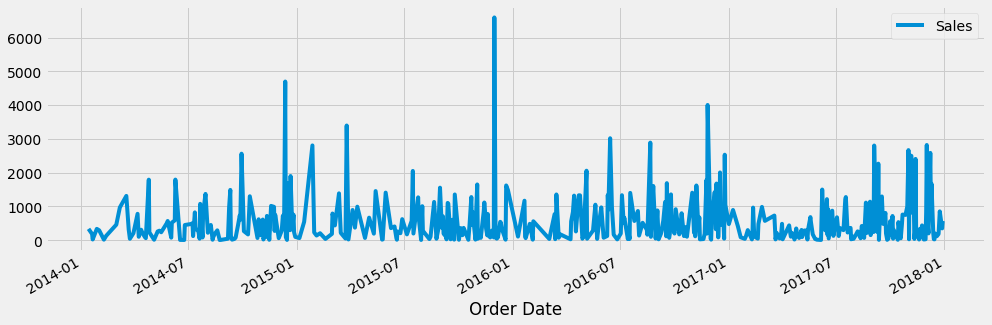

In [189]:
plt.figure(figsize=(8, 8), dpi=150);
df_west.plot();

In [190]:
df_west['Year']         = pd.DatetimeIndex(df_west.index).year
df_west['Month']        = pd.DatetimeIndex(df_west.index).month
df_west['Weekday Name'] = pd.DatetimeIndex(df_west.index).day_name()

In [191]:
df_west.head()

,Sales,Year,Month,Weekday Name
Order Date,,,,
2014-01-13,333.999,2014,1,Monday
2014-01-19,181.470,2014,1,Sunday
2014-01-20,19.300,2014,1,Monday
2014-01-27,333.000,2014,1,Monday
2014-01-31,290.666,2014,1,Friday


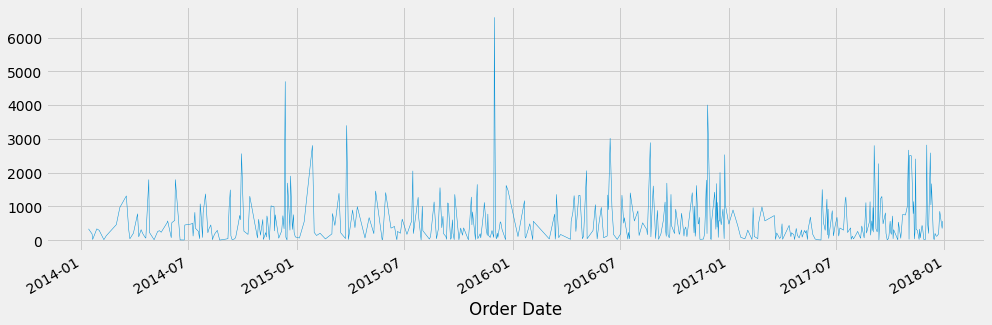

In [192]:
df_west['Sales'].plot(linewidth=0.5)

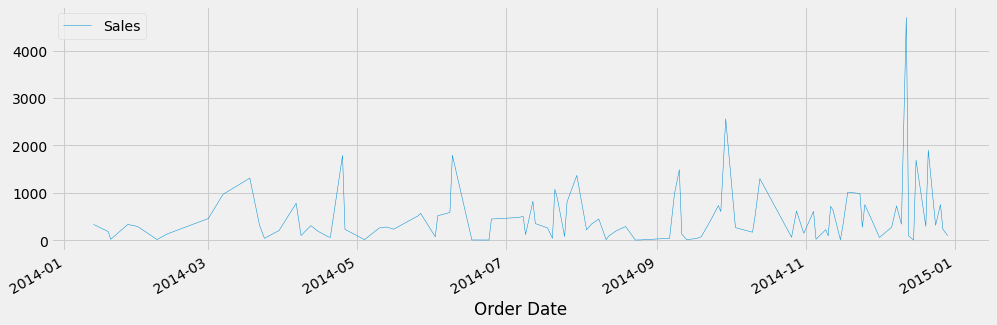

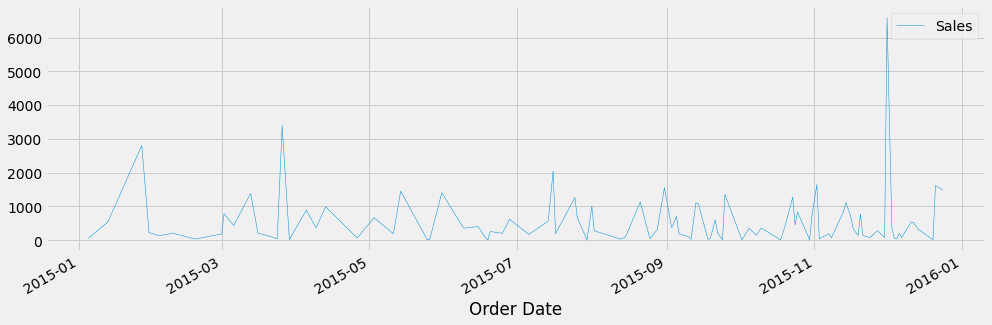

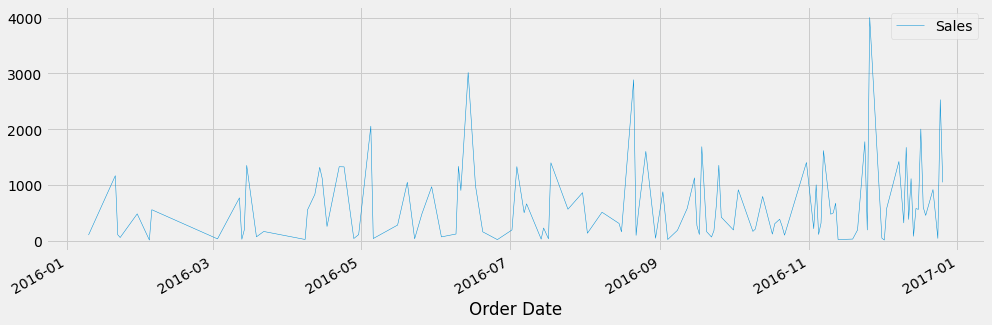

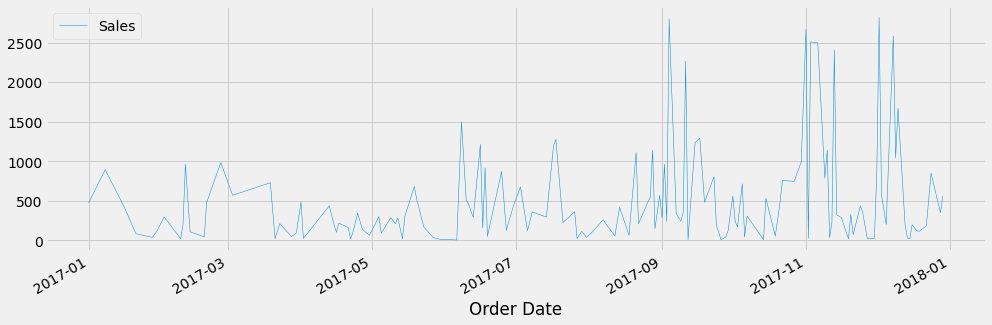

In [193]:
cols_plot = ['Sales']

df_west.loc['2014'][cols_plot].plot(linewidth=0.5);
df_west.loc['2015'][cols_plot].plot(linewidth=0.5);
df_west.loc['2016'][cols_plot].plot(linewidth=0.5);
df_west.loc['2017'][cols_plot].plot(linewidth=0.5);

In [194]:
# weekly sales
data_columns = ['Sales']

# Resample to weekly frequency, aggregating with mean
df_west_weekly = df_west[data_columns].resample('W').sum()
df_west_weekly.head(3)

,Sales
Order Date,
2014-01-19,515.469
2014-01-26,19.300
2014-02-02,623.666


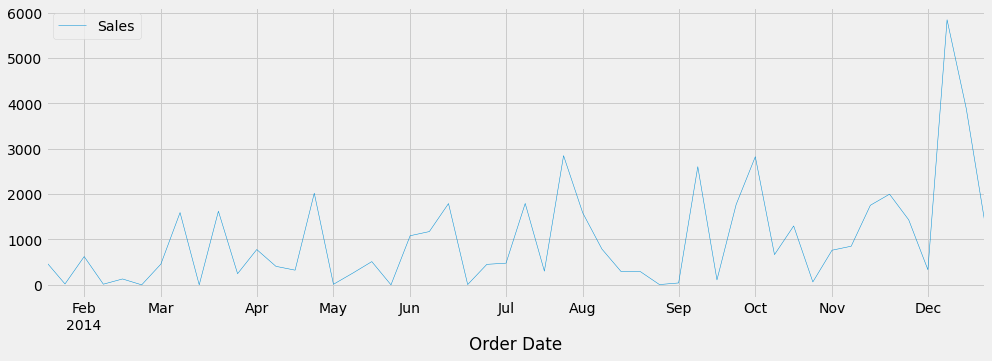

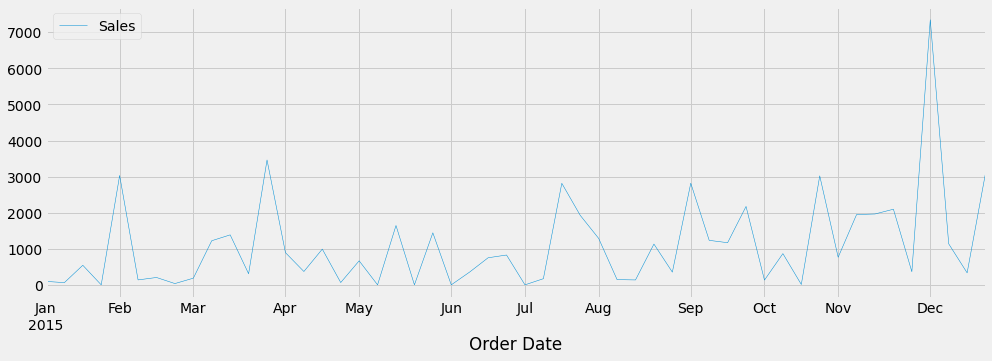

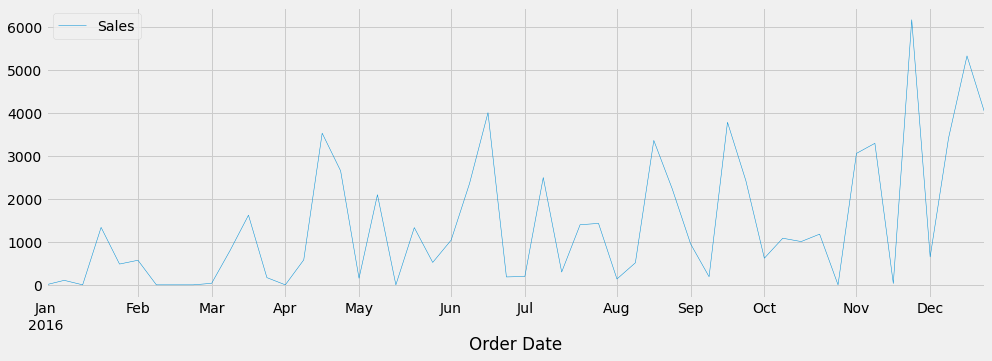

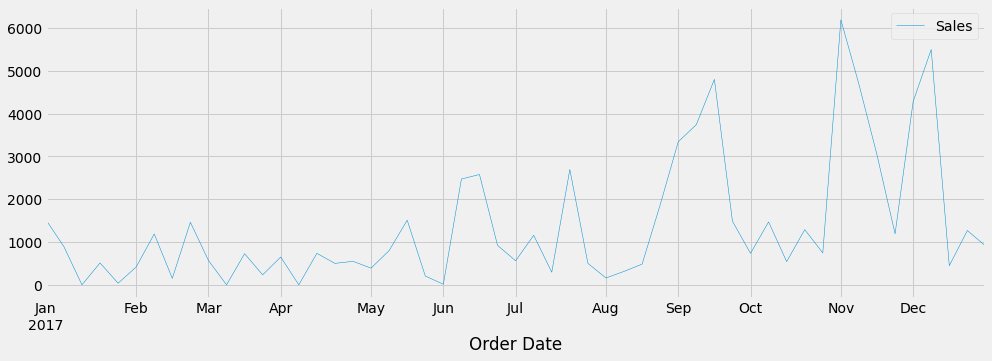

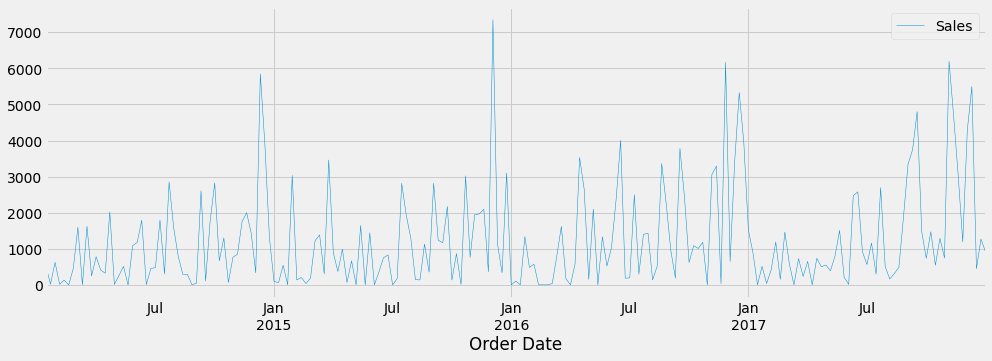

In [195]:
cols_plot = ['Sales']

df_west_weekly.loc['2014'][cols_plot].plot(linewidth=0.5);
df_west_weekly.loc['2015'][cols_plot].plot(linewidth=0.5);
df_west_weekly.loc['2016'][cols_plot].plot(linewidth=0.5);
df_west_weekly.loc['2017'][cols_plot].plot(linewidth=0.5);
df_west_weekly[cols_plot].plot(linewidth=0.5);

In [196]:
# monthly sales
data_columns = ['Sales']

# Resample to weekly frequency, aggregating with mean
df_west_monthly = df_west[data_columns].resample('M').sum()
df_west_monthly.head(3)

,Sales
Order Date,
2014-01-31,1158.435
2014-02-28,144.128
2014-03-31,3920.732


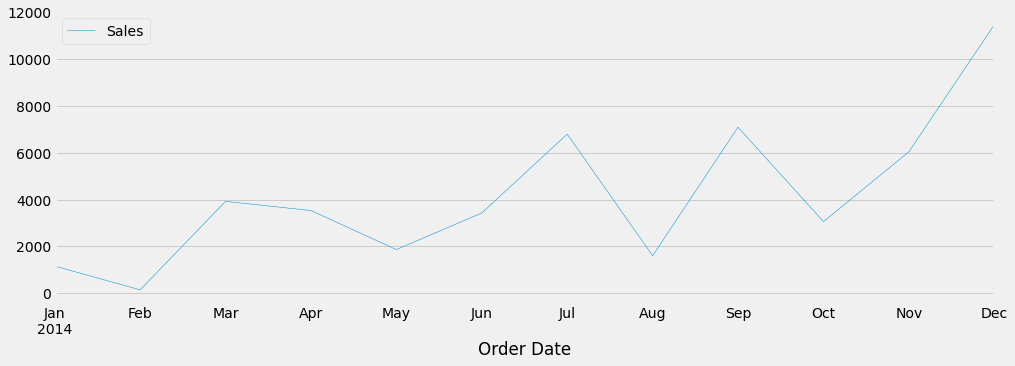

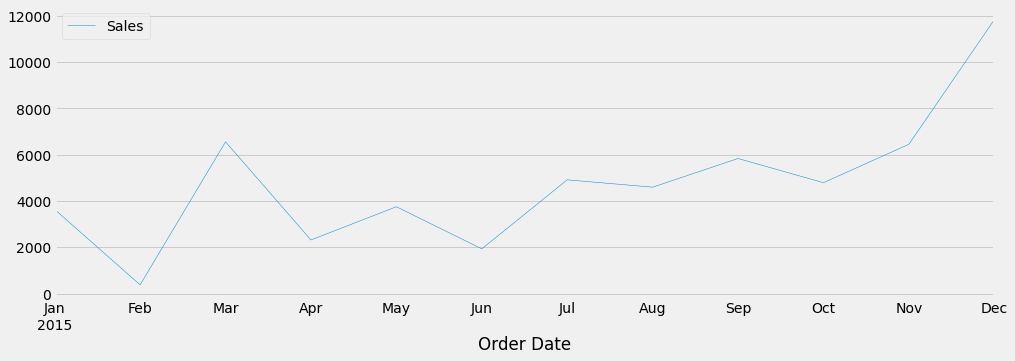

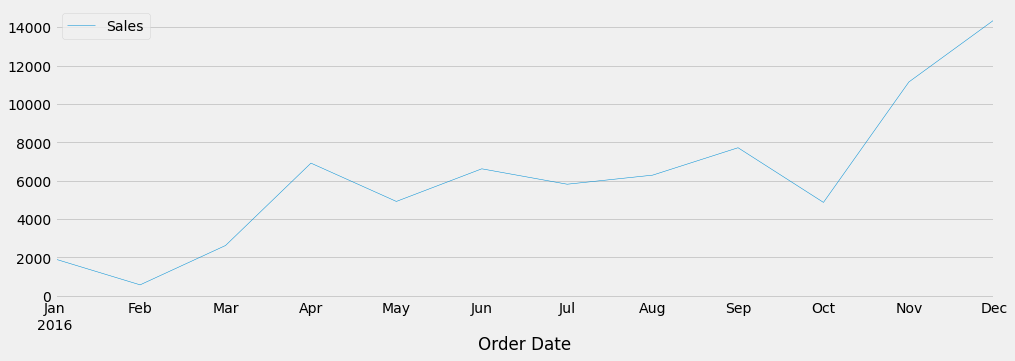

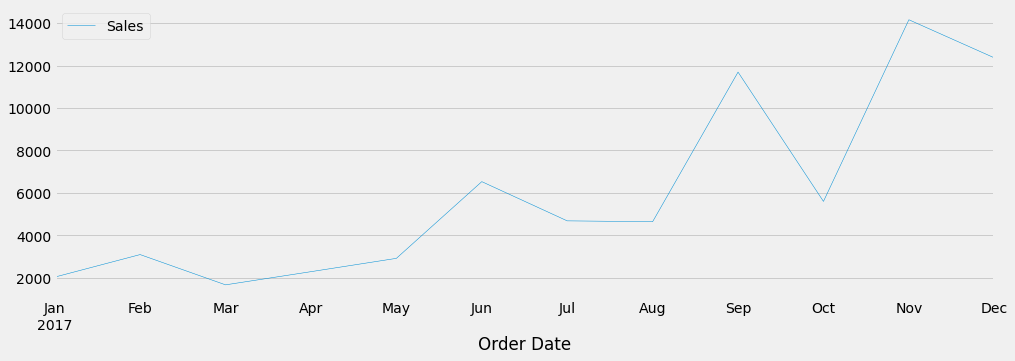

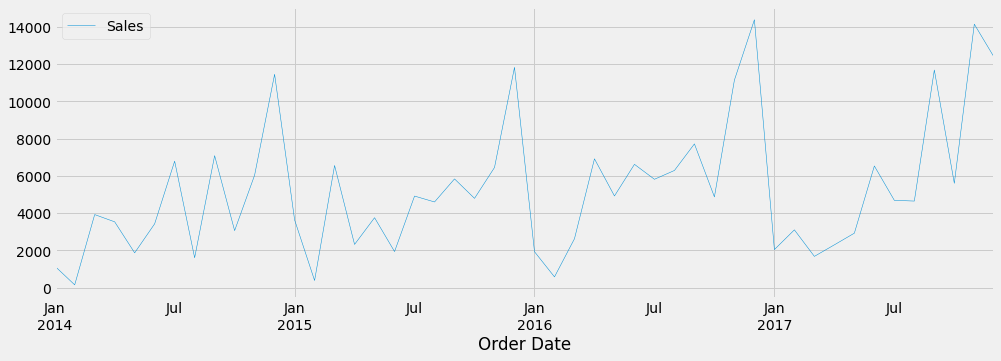

In [197]:
cols_plot = ['Sales']

df_west_monthly.loc['2014'][cols_plot].plot(linewidth=0.5);
df_west_monthly.loc['2015'][cols_plot].plot(linewidth=0.5);
df_west_monthly.loc['2016'][cols_plot].plot(linewidth=0.5);
df_west_monthly.loc['2017'][cols_plot].plot(linewidth=0.5);
df_west_monthly[cols_plot].plot(linewidth=0.5);

observation
.Every year, there is slight uptrend visible
.sales up in the months of Sep-Oct-Nov-Dec
.Consolidated 4 years - slight uptrend in sales numbers
.sales picks up in the last QTR of every calender year, indicates seasonality






In [198]:
# define a function to check trend and plot

def detect_trend (X_df):
    coefficients, residuals, _, _, _ = np.polyfit(range(len(X_df)),
                                                  X_df,
                                                  1,
                                                  full=True)

    mse = residuals[0]/(len(X_df))
    nrmse = np.sqrt(mse)/(X_df.max() - X_df.min())

    print('Slope ' + str(coefficients[0]))
    print('NRMSE: ' + str(nrmse))

    plt.xticks(rotation=90)
    plt.plot(X_df, 
             marker='.', 
             linestyle='-', 
             linewidth=0.5,
             color='blue',  
             label='Original')
    
    plt.plot([coefficients[0]*x + coefficients[1] for x in range(len(X_df))],
             marker='o', 
             markersize=8, 
             linestyle='-', 
             linewidth=0.5,
             color='orange',
             label='Regression line');
    plt.legend()
    plt.show()

Slope 631.8248496503497
NRMSE: 0.18815502066451967


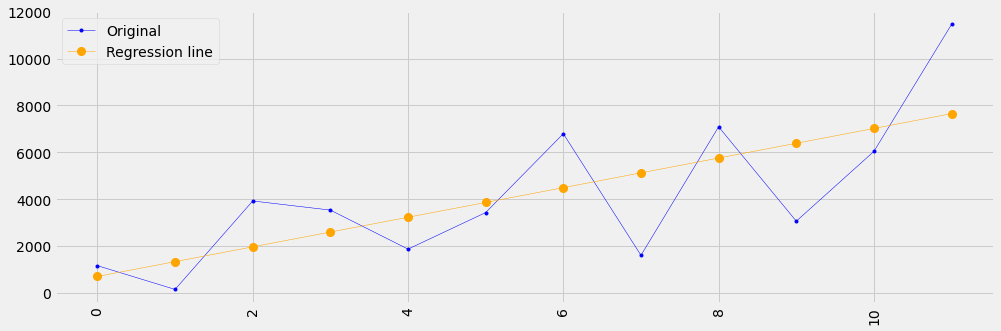

Slope 544.1930052447553
NRMSE: 0.17900545701604031


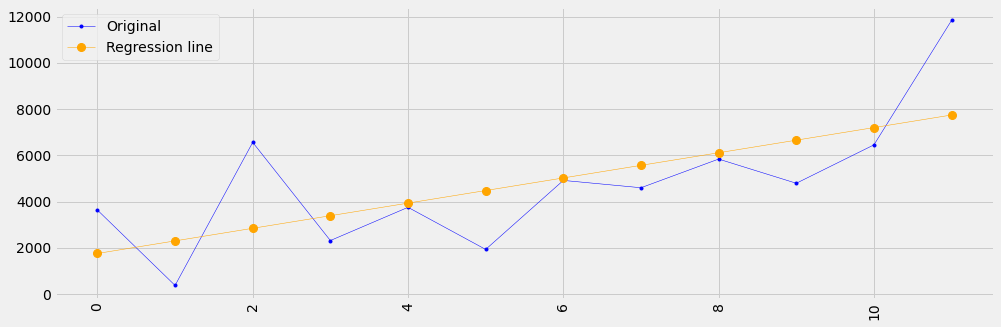

Slope 892.9129248251747
NRMSE: 0.14298617524778762


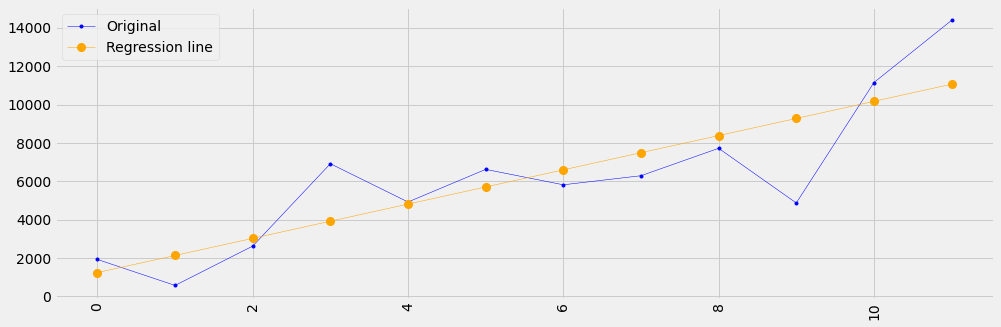

Slope 1017.0201416083916
NRMSE: 0.1813545893572126


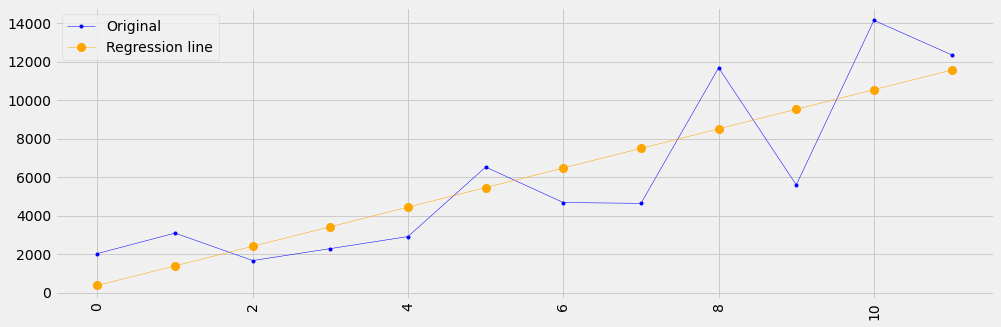

Slope [101.10702418]
NRMSE: 0.22953976947845606


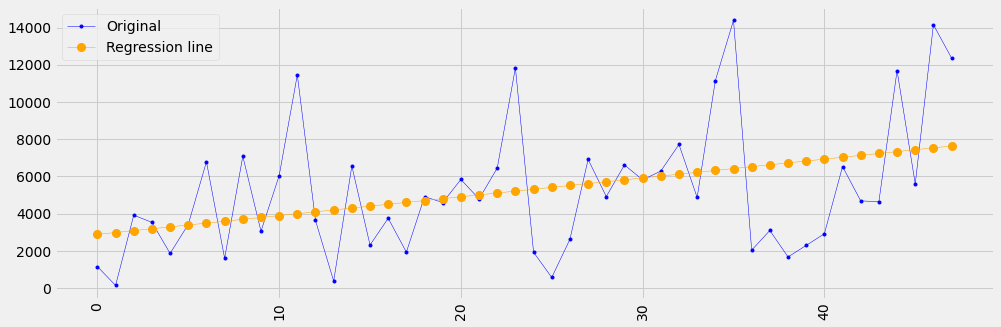

In [199]:
cols_plot = ['Sales']

detect_trend(df_west_monthly.loc['2014']['Sales'].values)
detect_trend(df_west_monthly.loc['2015']['Sales'].values)
detect_trend(df_west_monthly.loc['2016']['Sales'].values)
detect_trend(df_west_monthly.loc['2017']['Sales'].values)
detect_trend(df_west_monthly[cols_plot].values)

observation
Trend is more visible in the monthly sales data
Consolidated 4 years - uptrend in sales numbers
sales picks up in the last QTR of every calender year, indicates seasonality
The time-series has seasonality pattern, such as sales are always low at the beginning of the year and high at the end of the year. There is always an upward trend within any single year with a couple of low months in the mid of the year.

#### Stationarity test : Method 1 : Plots 

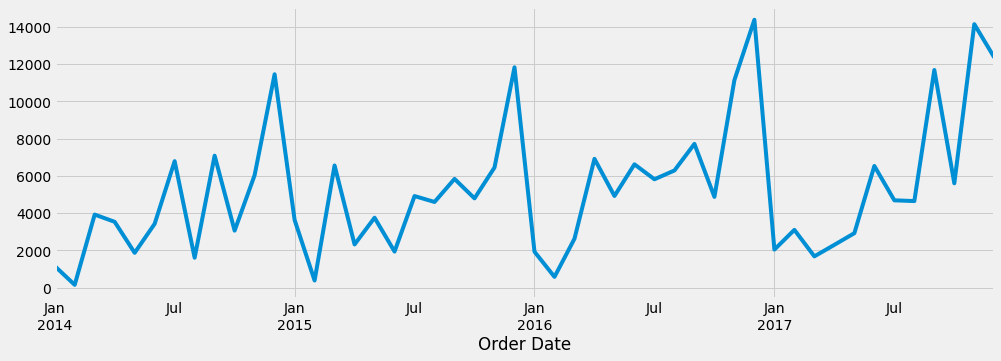

In [200]:
df_west_monthly['Sales'].plot();

#### Stationarity test : Method 2 : Summary Statistics

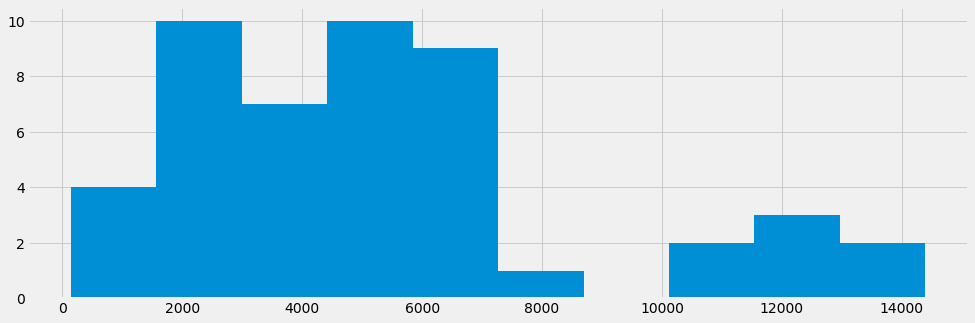

In [201]:
df_west_monthly['Sales'].hist();

In [202]:
X = df_west_monthly['Sales'].values
split = len(X) / 2
split = int(split)

X1, X2 = X[0:split], X[split:]

mean1, mean2 = X1.mean(), X2.mean()
var1,  var2  = X1.var(),  X2.var()

print('mean1     = {:10.2f}, mean2     = {:10.2f}'.format(mean1, mean2))
print('variance1 = {:10.2f}, variance2 = {:10.2f}'.format(var1,  var2))

mean1     =    4461.97, mean2     =    6063.56
variance1 = 8597313.32, variance2 = 15434925.30


#### Stationarity test : Method 3 : Augmented Dickey-Fuller test - (ADF) test 

In [203]:
years = ['2014', '2015', '2016', '2017']

for year in years:
    X = df_west_monthly.loc[year]['Sales'].values

    result = adfuller(X)
    
    print('\nFor the year : ', year)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')

    for key, value in result[4].items():
        print('\t%5s: %8.3f' % (key, value))

X = df_west_monthly['Sales'].values

result = adfuller(X)

print('\nFor the CONSOLIDATED 4 years')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')

for key, value in result[4].items():
    print('\t%5s: %8.3f' % (key, value))  


For the year :  2014
ADF Statistic: -1.001720
p-value: 0.752636
Critical Values:
	   1%:   -4.939
	   5%:   -3.478
	  10%:   -2.844

For the year :  2015
ADF Statistic: 2.146768
p-value: 0.998836
Critical Values:
	   1%:   -4.665
	   5%:   -3.367
	  10%:   -2.803

For the year :  2016
ADF Statistic: 0.747543
p-value: 0.990740
Critical Values:
	   1%:   -4.665
	   5%:   -3.367
	  10%:   -2.803

For the year :  2017
ADF Statistic: 4.552461
p-value: 1.000000
Critical Values:
	   1%:   -4.939
	   5%:   -3.478
	  10%:   -2.844

For the CONSOLIDATED 4 years
ADF Statistic: -4.915970
p-value: 0.000032
Critical Values:
	   1%:   -3.578
	   5%:   -2.925
	  10%:   -2.601


#### conclusion

1. Consolidated years - p-value is less than .05 or .01. hence H0 CAN be rejected. 
3. H0 : Not stationary
2. Means TS is stationary
4. Yearly- p-value method : p-value is less than 0.05 so we reject the null hypothesis for yearly TS

In [204]:
def test_stationarity(timeseries, reduced_timeseries=None, smoothing_type='R'):
     
    # Plot rolling statistics:
    orig = plt.plot(timeseries,
                    marker='.', 
                    linestyle='-', 
                    linewidth=0.5,
                    color='blue',  
                    label='Original')
    
    mean = plt.plot(reduced_timeseries, 
                    marker='.', 
                    linestyle='-', 
                    linewidth=0.5,
                    color='red',   
                    label='Reduced')
    
    if smoothing_type == 'R':
        title = 'Smoothing by Rolling MA'
    elif smoothing_type == 'E':
        title = 'Smoothing by Exponential weighted MA'
    else:
        title = 'Default MA'
        
    plt.legend(loc='best')
    plt.title(title)
    plt.show(block=False)
    
    # Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(reduced_timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
        
    print (dfoutput)

In [205]:
ts = df_west_monthly['Sales']

In [206]:
moving_avg = ts.rolling(window=12).mean()

In [207]:
moving_avg.head(20)

Order Date
2014-01-31            NaN
2014-02-28            NaN
2014-03-31            NaN
2014-04-30            NaN
2014-05-31            NaN
2014-06-30            NaN
2014-07-31            NaN
2014-08-31            NaN
2014-09-30            NaN
2014-10-31            NaN
2014-11-30            NaN
2014-12-31    4173.537333
2015-01-31    4379.943917
2015-02-28    4399.298583
2015-03-31    4619.233250
2015-04-30    4517.987500
2015-05-31    4675.327792
2015-06-30    4550.906292
2015-07-31    4394.518958
2015-08-31    4644.368708
Freq: M, Name: Sales, dtype: float64

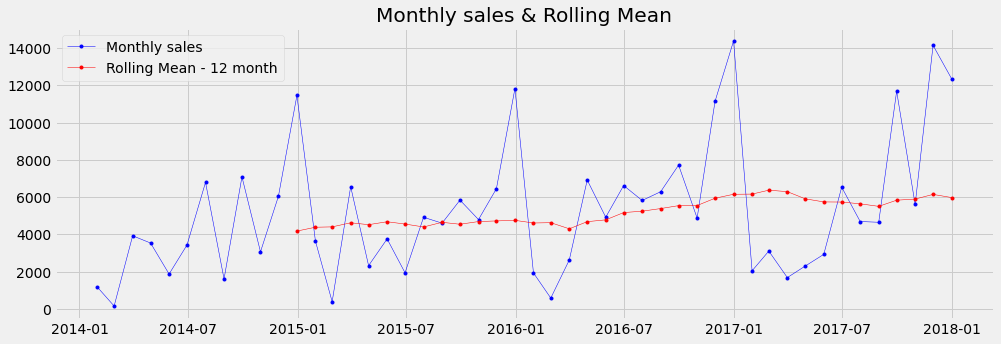

In [208]:
plt.plot(ts, marker='.', linestyle='-', linewidth=0.5, label='Monthly sales', c='b')
plt.plot(moving_avg, marker='.', linestyle='-', linewidth=0.5, color='red', label='Rolling Mean - 12 month');

plt.legend(loc='best')
plt.title('Monthly sales & Rolling Mean');

In [209]:
ts_moving_avg_diff = ts - moving_avg
ts_moving_avg_diff.head(12)

Order Date
2014-01-31            NaN
2014-02-28            NaN
2014-03-31            NaN
2014-04-30            NaN
2014-05-31            NaN
2014-06-30            NaN
2014-07-31            NaN
2014-08-31            NaN
2014-09-30            NaN
2014-10-31            NaN
2014-11-30            NaN
2014-12-31    7288.255167
Freq: M, Name: Sales, dtype: float64

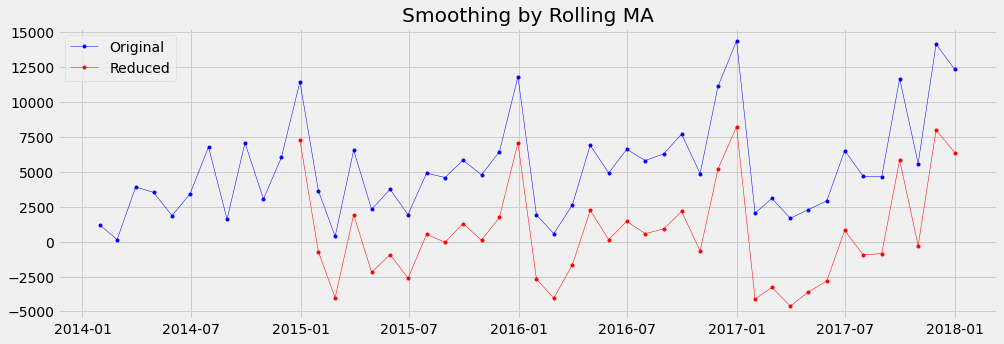

Results of Dickey-Fuller Test:
Test Statistic                 -4.931712
p-value                         0.000030
#Lags Used                      9.000000
Number of Observations Used    27.000000
Critical Value (1%)            -3.699608
Critical Value (5%)            -2.976430
Critical Value (10%)           -2.627601
dtype: float64


In [210]:
ts_moving_avg_diff.dropna(inplace=True)
test_stationarity(ts, ts_moving_avg_diff, 'R')

#### observation

- The rolling values appear to be varying slightly but there is no specific trend. 
- Also, the test statistic is smaller than the 5% critical values so we can say with 95% confidence that this is a stationary series

#### conclusion

1. p-value method : p-value of 0.000030 is lesser than 0.05 so we REJECT the null hypothesis. The null hypothesis is : the TS is NON-STATTIONARY. Hence it is proved that TS is stationary
    
2. Critical value  : our statistic value of -4.931712 is more than the value of -3.699608 at 1%. So this falls in the rejection region. Hence we REJECT the null hypothesis. i.e TS is stationary


In [211]:
ewma = pd.Series.ewm

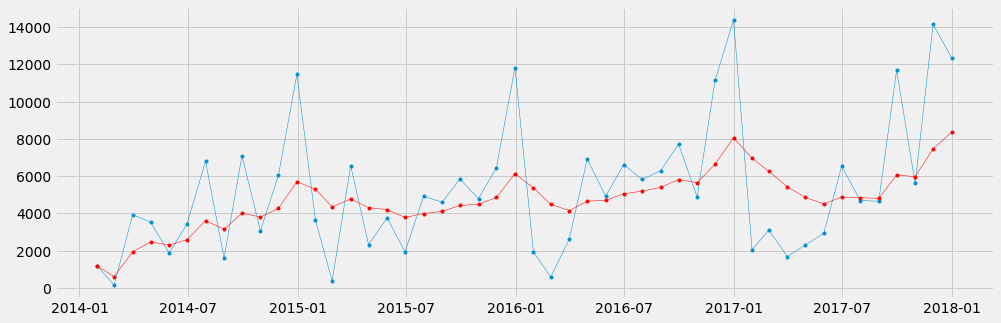

In [212]:
fwd_exp_weighted_avg = ewma(ts, span=10).mean() 

plt.plot(ts, marker='.', linestyle='-', linewidth=0.5,)
plt.plot(fwd_exp_weighted_avg, marker='.', linestyle='-', linewidth=0.5, color='red');

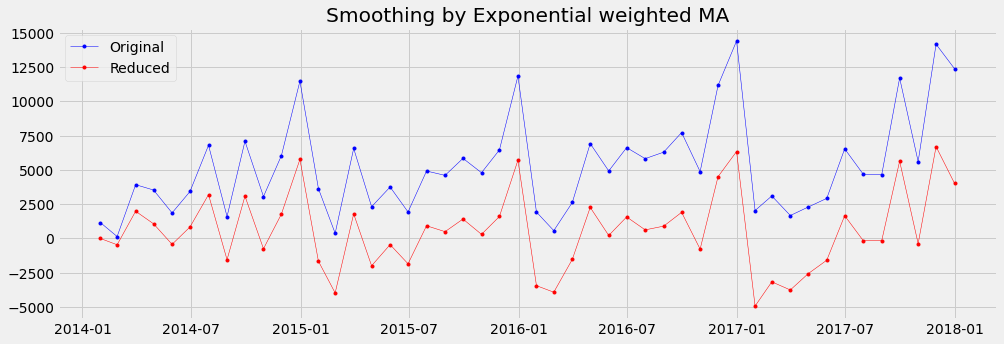

Results of Dickey-Fuller Test:
Test Statistic                 -4.806898
p-value                         0.000053
#Lags Used                      9.000000
Number of Observations Used    38.000000
Critical Value (1%)            -3.615509
Critical Value (5%)            -2.941262
Critical Value (10%)           -2.609200
dtype: float64


In [213]:
ts_ewma_diff = ts - fwd_exp_weighted_avg
test_stationarity(ts, ts_ewma_diff, 'E')

### Decomposition

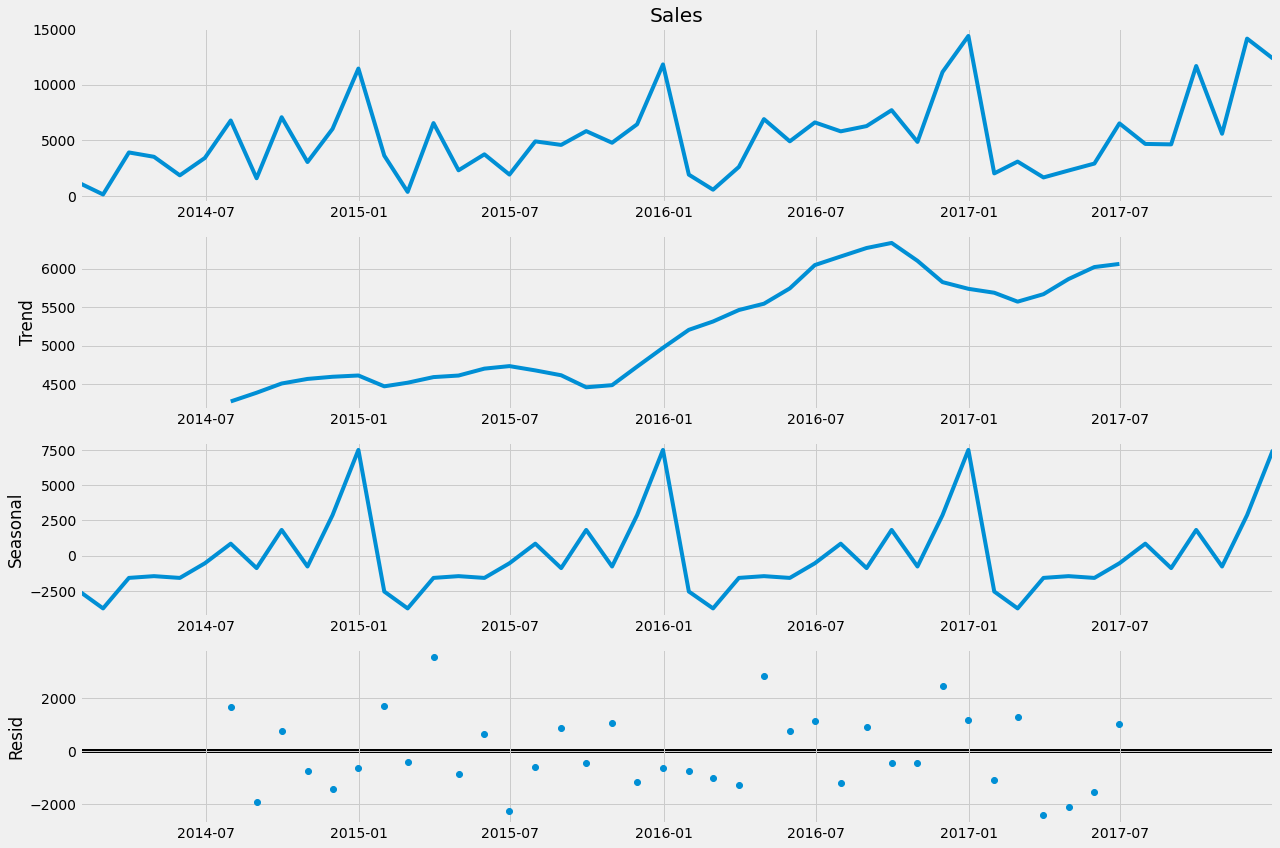

In [214]:
# Additive Decomposition 

rcParams['figure.figsize'] = 18, 12

result_additive = seasonal_decompose(df_west_monthly['Sales'],
                                     model='additive')

fig = result_additive.plot()

# Time series forecasting with ARIMA

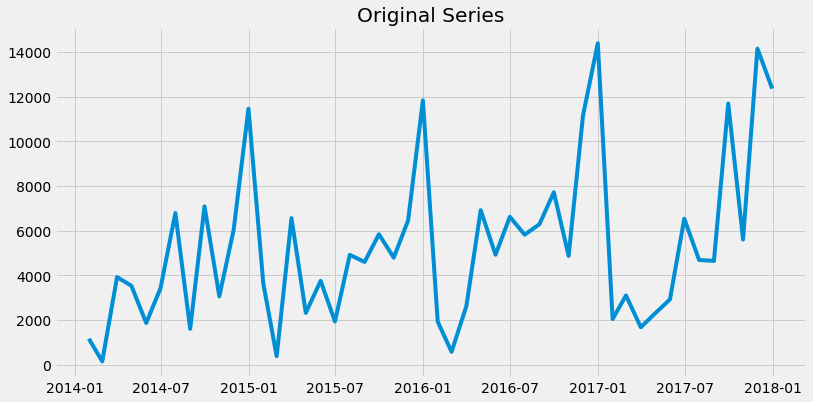

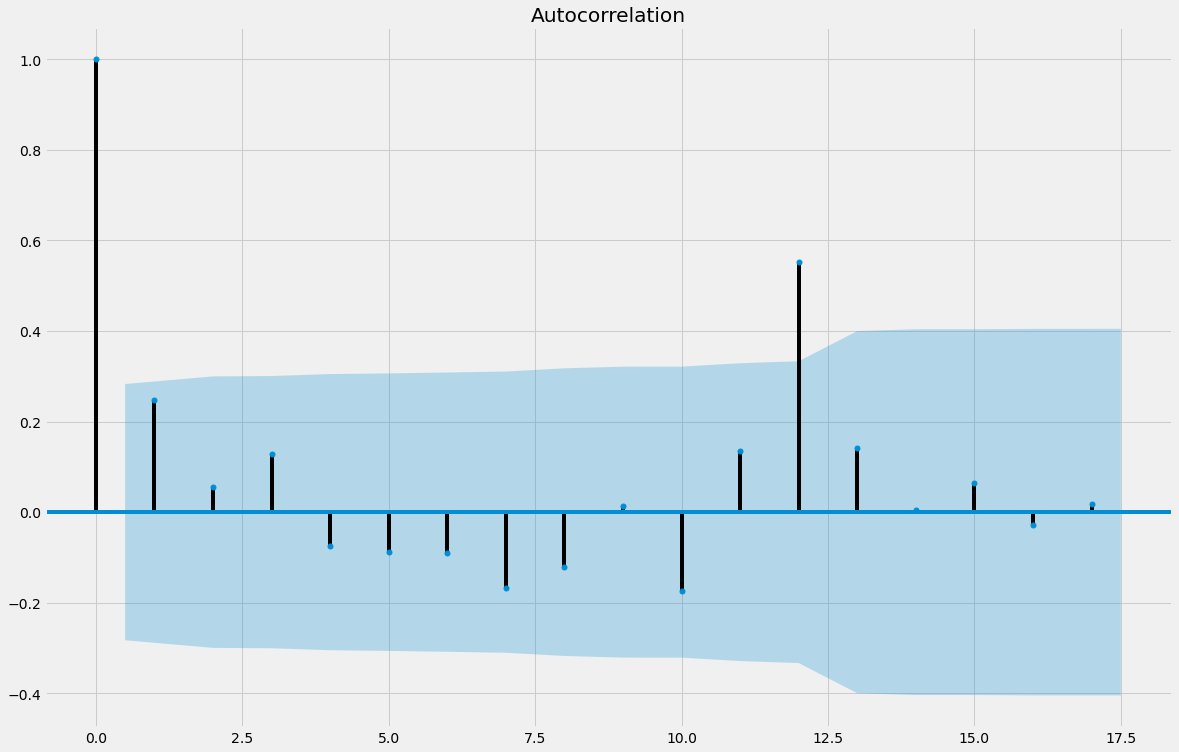

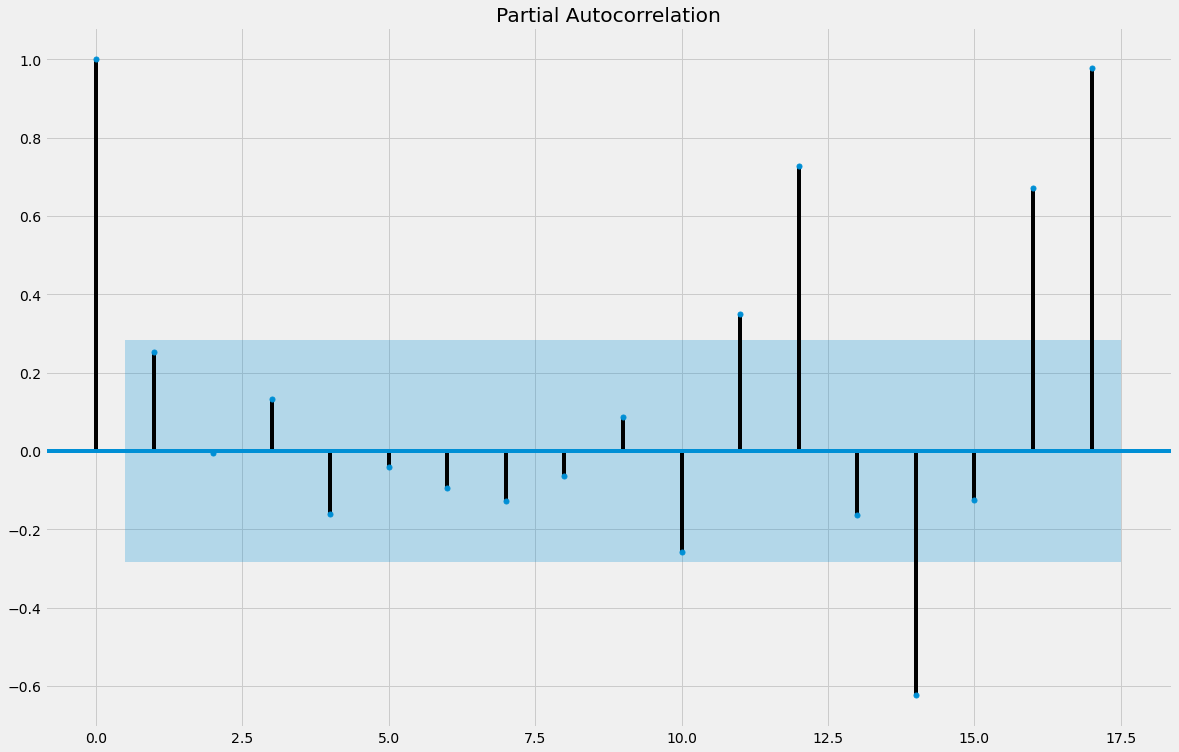

In [215]:
plt.figure(figsize=(12, 6))

plt.plot(ts)
plt.title('Original Series')
acf0 = plot_acf(ts)
acf1 = plot_pacf(ts)

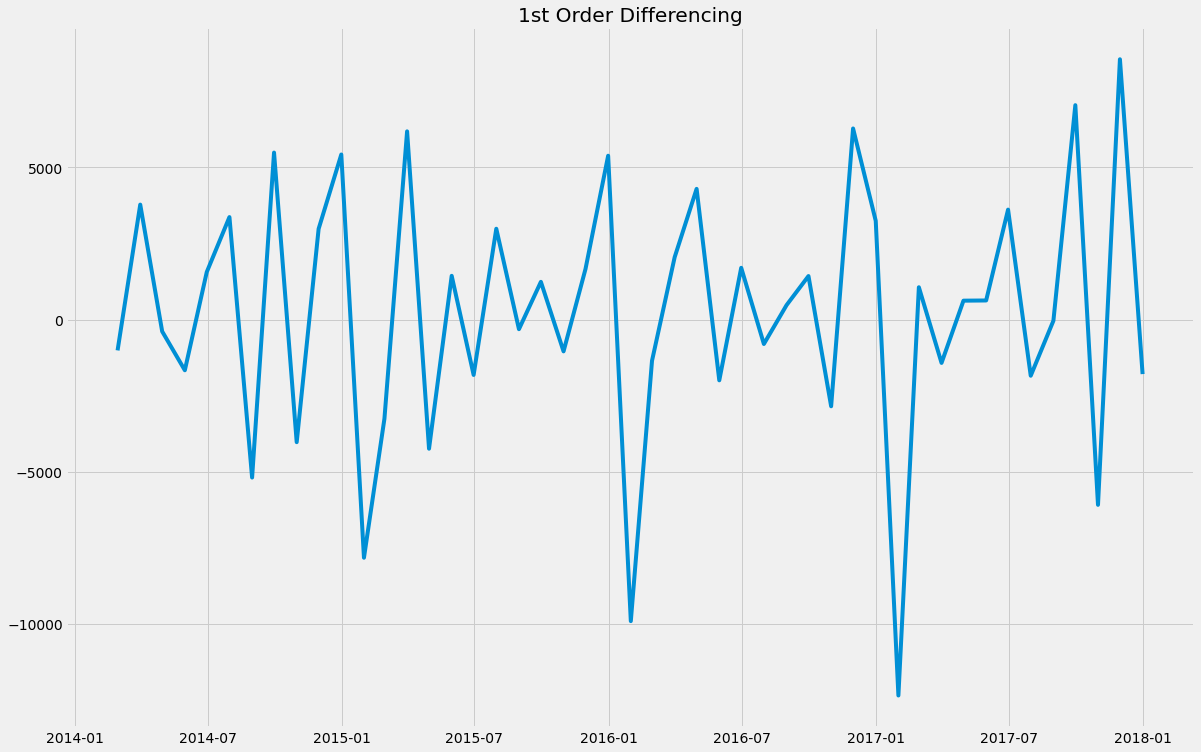

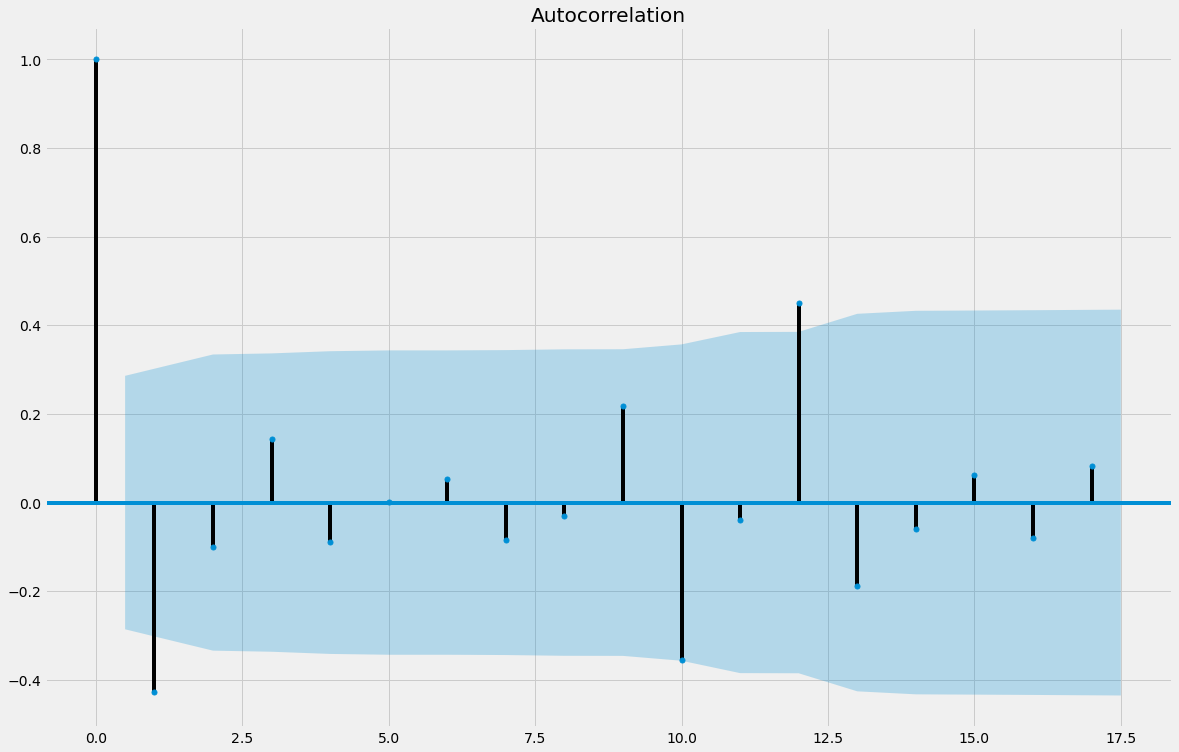

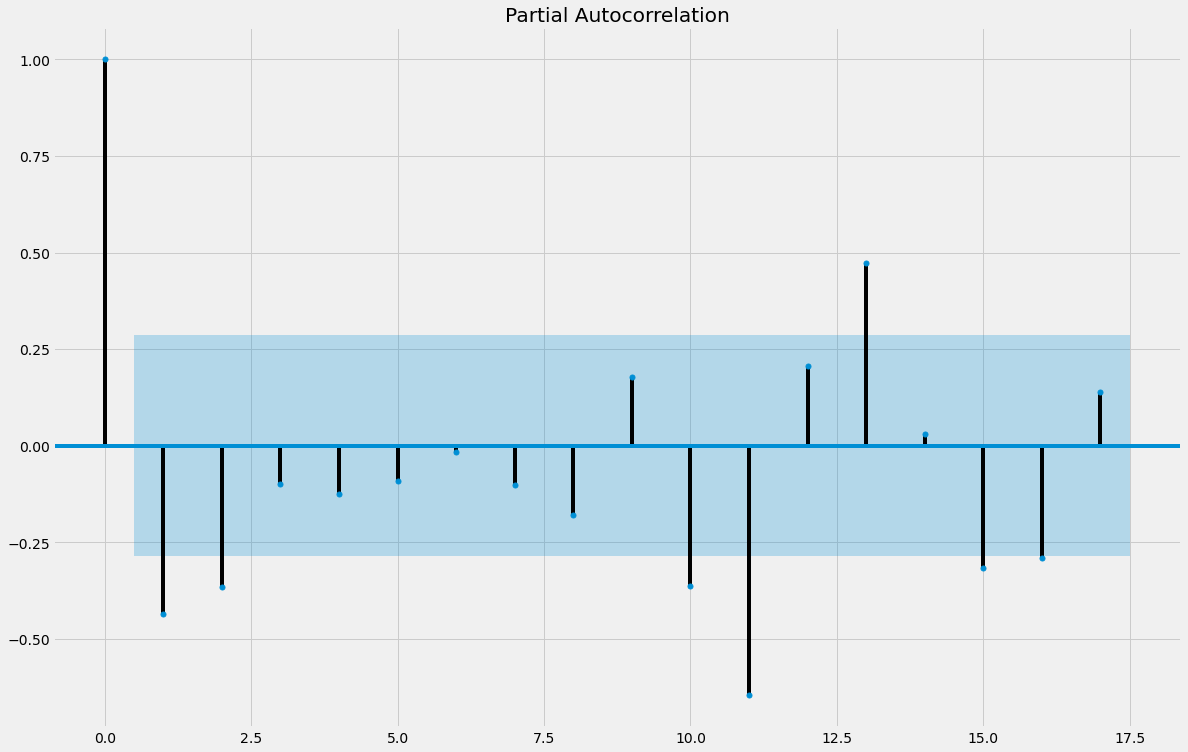

In [216]:
plt.plot(ts.diff()); 
plt.title('1st Order Differencing')
acf0 = plot_acf(ts.diff().dropna())
acf1 = plot_pacf(ts.diff().dropna())

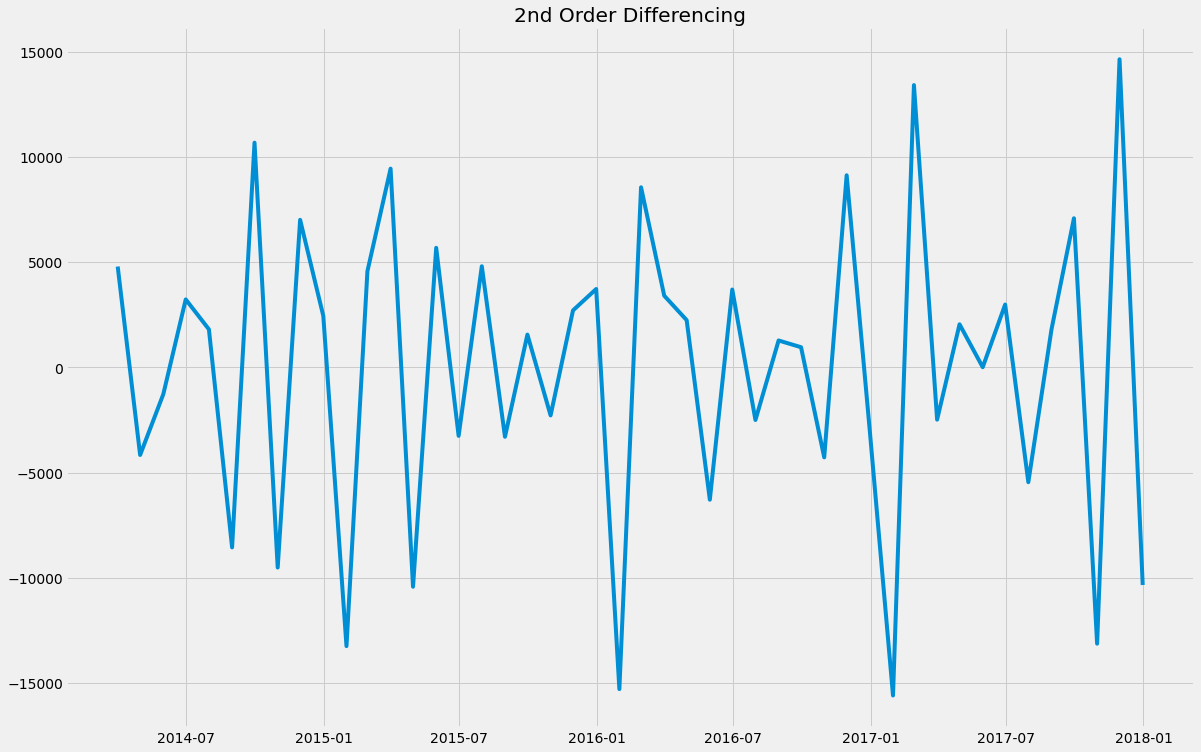

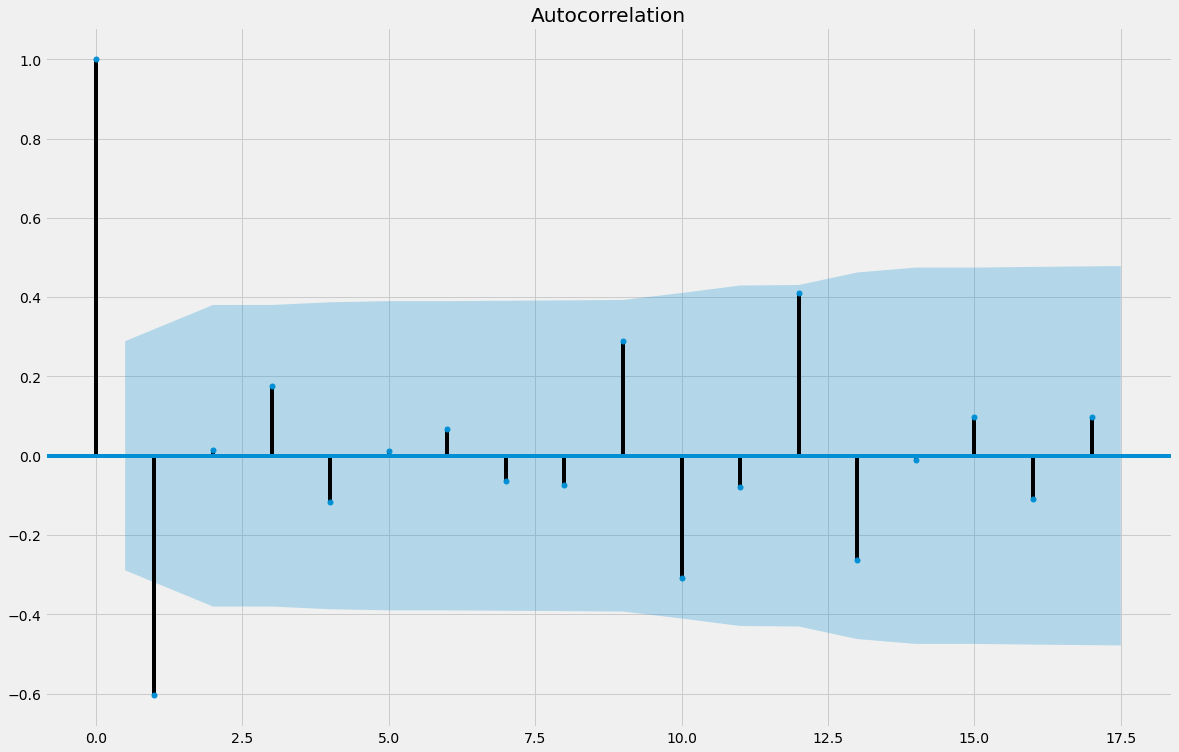

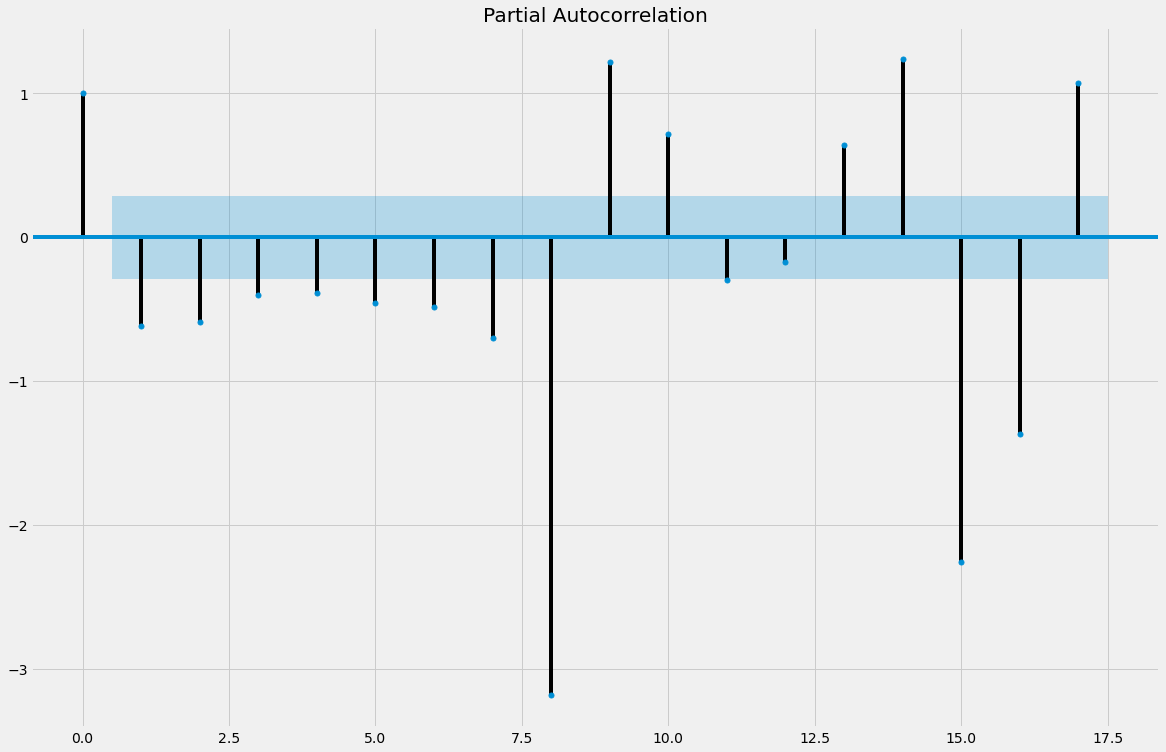

In [217]:
plt.plot(ts.diff().diff()); 
plt.title('2nd Order Differencing')
acf0 = plot_acf(ts.diff().diff().dropna())
acf1 = plot_pacf(ts.diff().diff().dropna())

In [245]:
p = q = range(0, 2)
d = [0]

In [246]:
import itertools
pdq = list(itertools.product(p, d, q))

In [247]:
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [249]:
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[2]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (1, 0, 0, 12)
SARIMAX: (1, 0, 0) x (1, 0, 1, 12)
SARIMAX: (1, 0, 0) x (1, 0, 0, 12)


In [250]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(ts,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:959.4675180118829
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1451.9863644153522
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:665.2907420082188
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1074.523801103965
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:923.3095190198068
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:3014.9173687080834
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:667.1491484340323
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:2698.0337787736494
ARIMA(1, 0, 0)x(0, 0, 0, 12)12 - AIC:918.6917927507692
ARIMA(1, 0, 0)x(0, 0, 1, 12)12 - AIC:1359.4226880340768
ARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:648.826387220594
ARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:1018.4988049977321
ARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:888.0272399327956
ARIMA(1, 0, 1)x(0, 0, 1, 12)12 - AIC:2914.4821749863227
ARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:650.3595119781942
ARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:2492.271601814485


In [223]:
# The above output suggests that SARIMAX(1, 0, 0)x(1, 0, 0, 12) yields the lowest AIC value of 648.82. 
# Therefore we should consider this to be optimal option.

In [251]:
mod = sm.tsa.statespace.SARIMAX(ts,
                                order=(1, 0, 0),
                                seasonal_order=(1, 0, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

# model diagnostics suggests that the model residuals are near normally distributed.

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0345      0.189     -0.182      0.855      -0.405       0.336
ar.S.L12       1.0468      0.062     16.900      0.000       0.925       1.168
sigma2      5.546e+06   1.56e+06      3.552      0.000    2.49e+06    8.61e+06


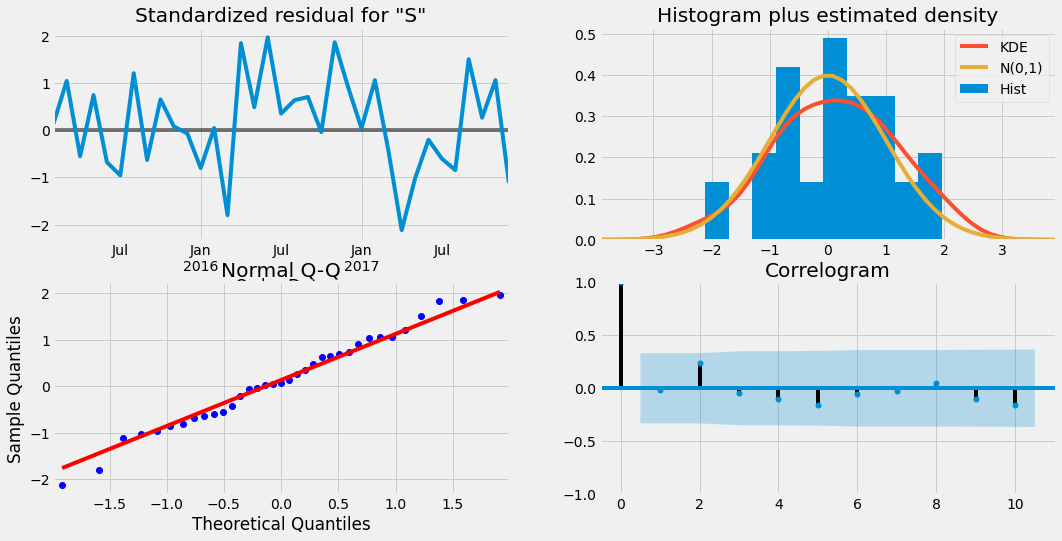

In [252]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

In [253]:
ts.head()

Order Date
2014-01-31    1158.435
2014-02-28     144.128
2014-03-31    3920.732
2014-04-30    3531.101
2014-05-31    1864.382
Freq: M, Name: Sales, dtype: float64

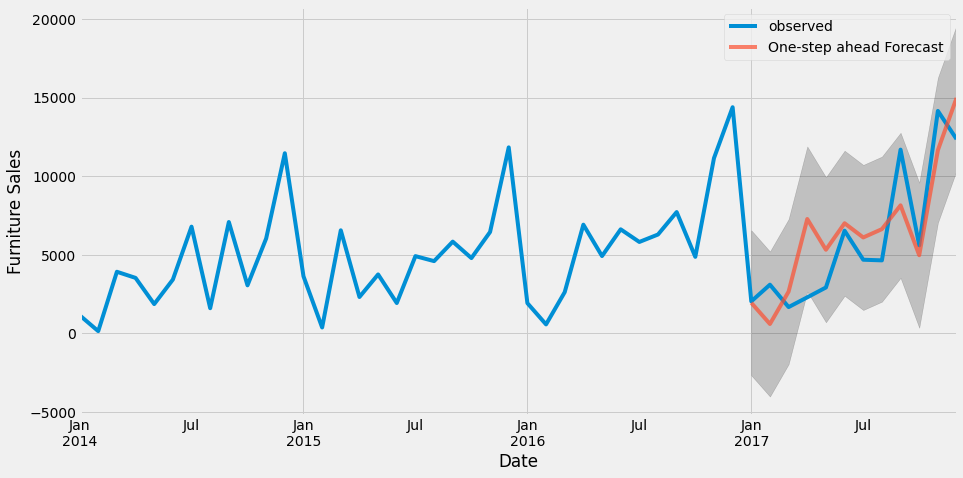

In [254]:
pred = results.get_prediction(start=pd.to_datetime('2017-01-31'), dynamic=False)
pred_ci = pred.conf_int()
ax = ts['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

# The line plot is showing the observed values compared to the rolling forecast predictions. 
# Overall, our forecasts align with the true values very well, showing an upward trend starts from the 
# beginning of the year and captured the seasonality toward the end of the year.